In [1]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.api import VAR
!pip install vnstock
from vnstock import *

In [2]:
# Import data
VIB = stock_historical_data(symbol = "VIB", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VIB['Close']))
VIB
#VIB["Close"].plot()

Observations:  1634


,Open,High,Low,Close,Volume,Ticker
Time,,,,,,
2017-06-02,3410,3440,3290,3320,2580,VIB
2017-06-05,3320,3410,3290,3290,39900,VIB
2017-06-06,3310,3320,3290,3320,53340,VIB
2017-06-07,3420,3420,3310,3340,69855,VIB
2017-06-08,3310,3310,3290,3310,50310,VIB
...,...,...,...,...,...,...
2023-12-11,19400,19400,19100,19200,2208600,VIB
2023-12-12,19300,19300,19050,19200,2262600,VIB
2023-12-13,19200,19400,19050,19050,3331000,VIB


In [3]:
# Preprocessing
scaler = MinMaxScaler(feature_range=(0,1))
def preprocessing(data):
    df = data[["Close", "Volume"]]
    df = df.reset_index(drop = True)
    df['Close'] = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))
    df['Volume'] = scaler.transform(np.array(df['Volume']).reshape(-1,1))
    print(df)
    return df

def SplitSet73(data):
    train_size = int(0.7*len(data))
    test_size = int(0.3*len(data))
    train_data = data[:train_size]
    test_data = data[train_size:]
    print("Train data:\n", train_data.shape)
    print("Test data: \n", test_data.shape)
    return train_size, test_size, train_data, test_data


In [4]:
df = preprocessing(VIB)

         Close      Volume
0     0.009107   -0.017851
1     0.008015    1.341712
2     0.009107    1.831330
3     0.009836    2.432969
4     0.008743    1.720947
...        ...         ...
1629  0.587614   80.347177
1630  0.587614   82.314390
1631  0.582149  121.236066
1632  0.576685  111.123133
1633  0.573042   64.758834

[1634 rows x 2 columns]


In [5]:
train_size = int(0.7*len(df))
test_size = int(0.3*len(df))
train_data = df[:train_size]
test_data = df[train_size:]
print("Train data:\n", train_data.shape)
print("Test data: \n", test_data.shape)

Train data:
 (1143, 2)
Test data: 
 (491, 2)


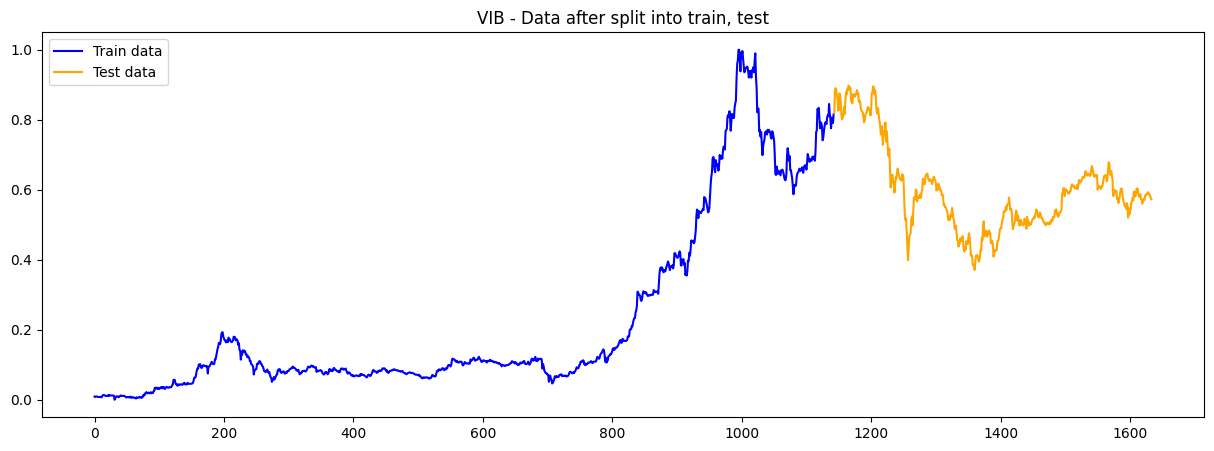

In [6]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, train_data['Close'], 'b')
plt.plot(test_data.index, test_data['Close'], 'orange')
plt.legend(['Train data', 'Test data'], loc='upper left')
plt.title('VIB - Data after split into train, test')
plt.show()

In [7]:
model_var = VAR(train_data)
for i in range(1,10):
    results = model_var.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print('BIC: ', results.bic)
    print()

Order = 1
AIC:  -2.730634016793958
BIC:  -2.7041513387367813

Order = 2
AIC:  -2.8245524727680418
BIC:  -2.7803836704029052

Order = 3
AIC:  -2.88462233667857
BIC:  -2.8227425388018688

Order = 4
AIC:  -2.8986704422665457
BIC:  -2.81905472028055

Order = 5
AIC:  -2.8911408710480075
BIC:  -2.7937642387781496

Order = 6
AIC:  -2.9001898458095683
BIC:  -2.78502725932099

Order = 7
AIC:  -2.8996428458220422
BIC:  -2.7666692032353932

Order = 8
AIC:  -2.894123533368622
BIC:  -2.743313674675118

Order = 9
AIC:  -2.895630716225489
BIC:  -2.72695942310121



In [8]:
result = model_var.fit(5)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 31, Dec, 2023
Time:                     03:59:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -2.79376
Nobs:                     1138.00    HQIC:                  -2.85436
Log likelihood:          -1562.44    FPE:                  0.0555129
AIC:                     -2.89114    Det(Omega_mle):       0.0544551
--------------------------------------------------------------------
Results for equation Close
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000798         0.000437            1.827           0.068
L1.Close          1.109097         0.030462           36.410           0.000
L1.Volume         0.000007         0.000013            0.540           0.589

In [9]:
lags_order = result.k_ar
lags_order

5

In [10]:
#Predict the price
y_pred_test = []
for i in range(test_data.shape[0] - lags_order):
    forecast_input = test_data[i:(i+lags_order)].values
    pred = result.forecast(forecast_input, steps=1)
    y_pred_test.append(list(pred[0]))

y_pred_test_price = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[0].reshape(-1, 1)))
y_pred_test_vol = np.array(scaler.inverse_transform(np.array(y_pred_test).transpose()[1].reshape(-1, 1)))
y_pred_test_price.shape

(486, 1)

In [11]:
number_of_days_to_predict = 60

In [12]:
ndays_pred = result.forecast(df[-lags_order-number_of_days_to_predict:-number_of_days_to_predict].values, steps=number_of_days_to_predict)
ndays_pred = np.array(ndays_pred)[:, 0]
ndays_pred = scaler.inverse_transform(np.array(ndays_pred).reshape(-1, 1))

ndays_pred.shape

(60, 1)

In [13]:
y_test = test_data['Close'].values[lags_order:]
y_test = scaler.inverse_transform(np.array(y_test).reshape(-1, 1))
y_test.shape

(486, 1)

In [14]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))

print("RSME test :", RSME(y_pred_test_price, y_test))
print("MAE test : ", MAE(y_pred_test_price, y_test))
print("MAPE test: ", MAPE(y_pred_test_price, y_test))
print("MSLR test: ", MSLE(y_pred_test_price, y_test))

RSME test : 437.69986671909487
MAE test :  322.69088278817975
MAPE test:  1.6876006411566582
MSLR test:  0.0005259231545327432


In [15]:
lags = lags_order - 1

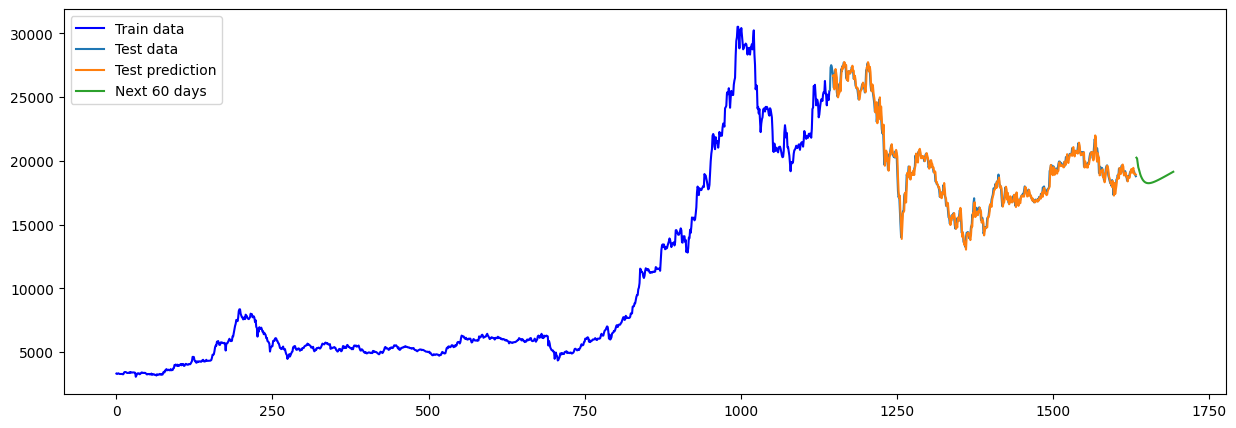

In [16]:
plt.figure(figsize=(15,5))
plt.plot(train_data.index, scaler.inverse_transform(np.array(train_data['Close']).reshape(-1, 1)), color="blue")
plt.plot(test_data.index, scaler.inverse_transform(np.array(test_data['Close']).reshape(-1, 1)).reshape(-1, 1))
plt.plot(test_data.index[-len(y_pred_test_price):], y_pred_test_price)
pred_ind = pd.RangeIndex(start = len(df['Close']), stop = len(df['Close'])+60)
plt.plot(pred_ind, ndays_pred)

plt.legend(["Train data", "Test data", "Test prediction", "Next 60 days"],loc = 'upper left')
plt.show()